# A Quick Tour of Powder Diffraction Visualization with Jupyter 


<img src="resources/nsls2.PNG" alt="NSLS2" style="width: 450px; height: 250px;"/>

### Dan Olds, Hard X-ray Scattering and Spectroscopy, PDF, NSLS-II 
### NSLS-II and CFN Users' Meeting 2022

The PDF beamline at NSLS-II is a high-energy powder diffraction beamline that allows for measurements of powder diffraction, total scattering methods, and small-angle scattering.

<img src="resources/PDF_beamline.PNG" alt="PDF Beamline" style="width: 700px; height: 450px;"/>



## Setting up

In [1]:
from tiled.client import from_uri, from_profile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#%matplotlib widget

Grab our catalogue

In [2]:
c = from_uri("https://tiled-demo.blueskyproject.io/api")

Raw data from PDF is stored on the DataBroker as 2D diffraction images. For analysis of this data, it is regularly reduced via a process which azimuthally integrates the data into 1D patterns. 

<img src="resources/pdf_data.PNG" alt="Drawing" style="width: 340px; height: 400px;"/>

For this tutorial, we will not be looking at the raw data stored in DataBroker, rather we will be looking at some fully reduced data that has been stored in a file-based .chi format common in the powder diffraction community. Note here that Tiled does not require your data to be stored in the facility standard DataBroker formats, but can in fact serve files directly from a file system!  This means that with a little bit of work, you can use tiled with the file formats you are accustomed, augmenting your standard data processing.

In this example, a folder-baseds structure was used, where measurements from 10 different samples were all placed in the corresponding sample-named folder.

In [3]:
my_cat = c['um2022']['olds']
my_cat

<Node {'air', 'BaTiO3_VT', 'epoxy', 'ethanol_fast', ...} ~10 entries>

Can see the 'node', but if we want to see all the entries, must cast as a list.

In [4]:
list(my_cat)

['air',
 'BaTiO3_VT',
 'epoxy',
 'ethanol_fast',
 'ethanol_long',
 'kapton',
 'LaB6_fast',
 'LaB6_long',
 'quartz_fast',
 'quartz_long']

## Walking around the data tree
Let's look at the 'long' measurement of LaB6

In [5]:
my_cat['LaB6_long']

<Node {'LaB6_long_20210913-230727_322be6_0001_mean_tth'}>

Again, even though there is a single entry into this node, we need to select it to go down another layer in the tree.

In [6]:
my_cat['LaB6_long']['LaB6_long_20210913-230727_322be6_0001_mean_tth']

<DataFrameClient ['I']>

We see at this point that we have a Pandas DataFrame with a column labeled 'I' for intensity.  As this is no longer a node, but a data layer, we can read this.

In [7]:
my_cat['LaB6_long']['LaB6_long_20210913-230727_322be6_0001_mean_tth'].read()

,I
tth,
0.006569,0.000000
0.011708,31.508301
0.019716,40.981030
0.027733,34.771587
0.035780,34.175527
...,...
16.147108,0.000000
16.154558,0.000000
16.162008,0.000000


Or plot it directly via the pandas `.plot` method

<AxesSubplot:xlabel='tth'>

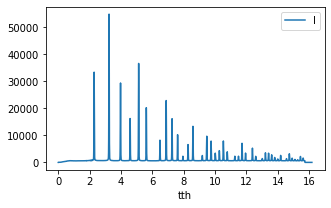

In [8]:
my_cat['LaB6_long']['LaB6_long_20210913-230727_322be6_0001_mean_tth'].read().plot(figsize=(5,3))

While this is nice, you might be thinking - that is a very long name to type out.  Sort of a hassle to copy/paste a big giant string like that every time you want to access something.

Say hello to indexers :-)

## Indexers

In [9]:
my_cat['LaB6_long'].values_indexer[0]

<DataFrameClient ['I']>

In [10]:
my_cat['LaB6_long']['LaB6_long_20210913-230727_322be6_0001_mean_tth']

<DataFrameClient ['I']>

Returns the '0th' enttry of the node - which is the dataframe (that we could read / plot just as before).

<AxesSubplot:xlabel='tth'>

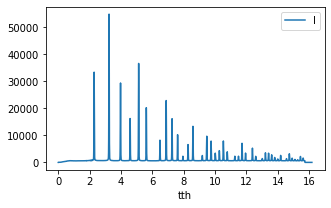

In [11]:
my_cat['LaB6_long'].values_indexer[0].read().plot(figsize=(5,3))

In addition to the values_indexer, there is keys_indexer - which returns the key name for that corresponding node.

In [12]:
my_cat['LaB6_long'].keys_indexer[0]

'LaB6_long_20210913-230727_322be6_0001_mean_tth'

If you wanted both the keys and values, you can use the items_indexer to get a tuple of key and values.

In [13]:
my_cat['LaB6_long'].items_indexer[0]

('LaB6_long_20210913-230727_322be6_0001_mean_tth', <DataFrameClient ['I']>)

## Looking at lots of data
Back to our data!  Let's see what other datasets we could plot.

In [14]:
list(my_cat)

['air',
 'BaTiO3_VT',
 'epoxy',
 'ethanol_fast',
 'ethanol_long',
 'kapton',
 'LaB6_fast',
 'LaB6_long',
 'quartz_fast',
 'quartz_long']

ethanol_fast contains many short, fast mesaurements of ethanol in a kapton capillary.

In [15]:
len(my_cat['ethanol_fast'])

1001

Let's load up some of these, and put them in a pandas dataframe.
For simplicity, we'll label the column names of the DataFrame we are putting the data in as sequential integers, and we'll only load 10 at first (to keep the time short).

In [16]:
temp_df_list = []
for i in range(20):
#for i in range(0,len(my_cat['ethanol_fast'])):
    temp_df_list.append(my_cat['ethanol_fast'].values_indexer[i].read())

ethanol_data = pd.concat(temp_df_list,axis=1)

Looking at the DataFrame we just created...

,I,I,I,I,I,I,I,I,I,I,I,I,I,I,I,I,I,I,I,I
tth,,,,,,,,,,,,,,,,,,,,
0.006569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.011708,9.333333,-4.000000,16.666667,9.000000,19.333333,-2.000000,4.333333,-1.666667,-4.333333,2.333333,10.999999,9.833333,5.333333,-27.000001,10.333333,7.000000,18.333333,9.833333,10.166666,16.500000
0.019716,6.714287,8.571429,13.571430,16.571431,9.285716,2.714287,-1.857142,9.000002,29.142859,1.714286,-4.857143,13.142858,12.428573,14.857144,-4.714286,0.857142,-6.857143,11.142859,15.285717,-1.285715
0.027733,-14.800004,4.400001,5.400000,-11.300004,-2.600001,-6.400001,-0.900000,-1.600001,1.700001,-4.300003,-3.800002,15.500002,0.199998,5.699998,4.799999,-4.200001,9.500000,-4.600001,6.499999,8.399999
0.035780,5.266666,5.133332,-1.266669,-2.400003,-0.533333,11.600000,9.800002,6.200001,-2.666669,6.200000,6.266666,3.933333,10.066669,5.333333,9.400001,2.933333,-3.866669,3.400000,4.066666,7.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16.147108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16.154558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16.162008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


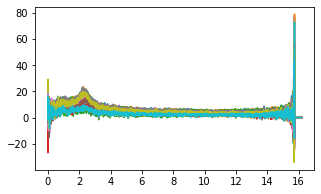

In [17]:
plt.figure(figsize=(5,3))
plt.plot(ethanol_data);
ethanol_data

Let's name the columns uniquely as sequential integers (0, 1, 2,....), and while we're at it, trim the dataset down a bit to remove the edges where data looks weird.

In [18]:
ethanol_data.columns = np.arange(len(ethanol_data.columns))

ethanol_data = ethanol_data.loc[.2:15,:]


This appears to have lots of variation in intensity between the different datasets!  

Let's take a look at this data in a different way, like a quick waterfall plot.

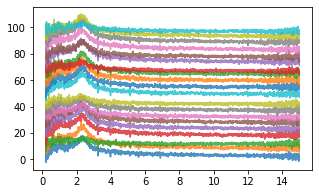

In [19]:
plt.figure(figsize=(5,3))
for i in range(len(ethanol_data.columns)):
    plt.plot(ethanol_data.loc[:,i]+i*5,alpha=.8)

So it's clear we have some issues between these scans having different amounts of intensity.  We'd like to average the runs together, but we probably don't want to do this as is.  Maybe we are lucky and if we normalize the data to say, the maximia of the low-angle peak.

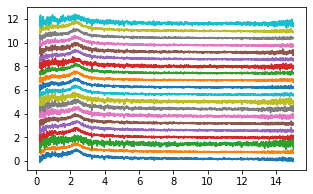

In [20]:
plt.figure(figsize=(5,3))
for i in range(len(ethanol_data.columns)):
    plt.plot(ethanol_data.loc[:,i]/max(ethanol_data.loc[1:3.7,i])+i*.6)

Some of those sets are still kind of ugly.  Let's try averaging this together.

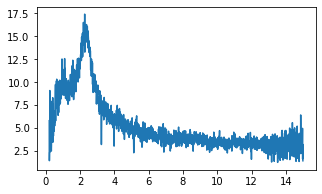

In [21]:
plt.figure(figsize=(5,3))
plt.plot((ethanol_data.loc[:,:]).mean(axis=1))

Now let's compare to a single, higher quality measurement.

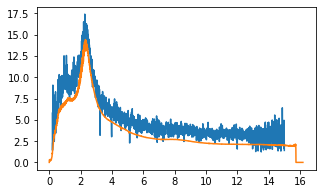

In [22]:
plt.figure(figsize=(5,3))
plt.plot((ethanol_data.loc[:,:]).mean(axis=1))
plt.plot(my_cat['ethanol_long'].values_indexer[0].read()/30)

After this insepection, it's clear that the features in the lower quality datasets are the same as the higher (peak position is the same), but due to the noise present, even averaging mutliple datasets together won't recover the data quality seen in the longer run measurment.  

## Temperature Dependent Study of BaTiO3

<img src="resources/hot_air_blower.PNG" alt="measurement on PDF" style="width: 700px; height: 500px;"/>

Let's say you have decided to do a temperature-dependent study of Barium Titanate.  This is an excellent system to study with the PDF beamline! 

To start with, let us load the data into a single Pandas DataFrame as before.

In [23]:
data = c['um2022']['olds']['BaTiO3_VT']

file_list = sorted(list(data))

temp_df_list = []
for i in range(len(file_list)):
    temp_df_list.append(data[file_list[i]].read())

bto_data = pd.concat(temp_df_list,axis=1)


In [24]:
len(bto_data.columns)

201

In this case, we happen to know the temperature these datasets were taken at (2 degree steps from 100 to 500 K), so we can put those in as column names.

In [25]:
bto_data.columns = np.arange(100,502,2,dtype=float) 

Let's have a quick look at the first, last and average data.

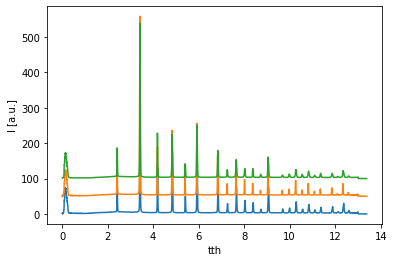

In [26]:
plt.figure(figsize=(6,4))
plt.plot(bto_data.loc[:,100])
plt.plot(bto_data.loc[:,500]+50)

plt.plot(bto_data.mean(axis=1)+100)
plt.xlabel('tth');
plt.ylabel('I [a.u.]');

By visual inspection, these all look very similar.  Let's take a waterfall plot of the whole dataset to see what we can see.

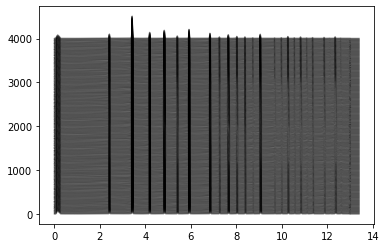

In [27]:
plt.figure(figsize=(6,4))
for i,t in enumerate(bto_data.columns):
    plt.plot(bto_data.loc[:,t]+i*20,color='k',alpha=.5)


We can observe only very subtle changes at this view.  We should zoom in on a single peak.



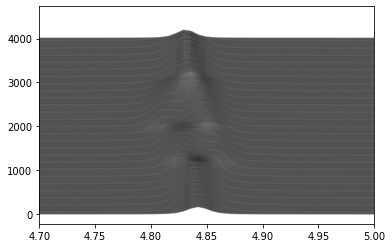

In [28]:
plt.figure(figsize=(6,4))
for i,t in enumerate(bto_data.columns):
    plt.plot(bto_data.loc[:,t]+i*20,color='k',alpha=.5)
plt.xlim(4.7,5);

We can finally see that there are some sublte, but real differences in the dataset! Maybe you want to quickly show this to your group, to verify you did in fact do the measurement correctly (and not find out weeks later when you analyze the data).  


Just to make things a little nicer, let's make a colormap based on the temperature, and perhaps tilt the perspective a little just for visual inspection. 

In [29]:
def make_colormap(num_ids,use_cmap='viridis'):
    num_colors = (num_ids)
    cm = plt.cm.get_cmap(name=use_cmap)
    currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]
    return currentColors

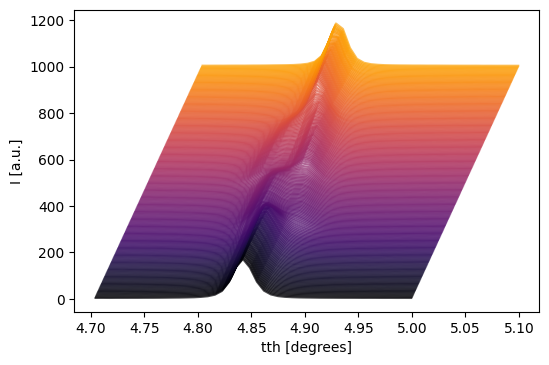

In [30]:
plt.figure(dpi=100)
cc = make_colormap(len(bto_data.columns)+50, use_cmap='inferno')

tth = bto_data.loc[4.7:5].index

for i in range(len(bto_data.columns)):
    this_t = bto_data.columns[i]
    plt.plot(tth+i*.0005,bto_data.loc[4.7:5,this_t]+i*5,c=cc[i],alpha=.7)
    
plt.xlabel('tth [degrees]');
plt.ylabel('I [a.u.]');

### We will explore this dataset using machine learning during the second tutorial on Wednesday!